In [1]:
import preprocessing.preprocessing as pp
import sampling
import random
import torch
from models import graphClassifier, nodeClassifier
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from visualization import mesh_viewer
import evaluation.evaluation as ev

In [2]:

nodesFileNerve =  "~/Documents/Intestine/nerve-mask/nodes_nerve_bs2_fh.csv"
edgesFileNerve = "~/Documents/Intestine/nerve-mask/edges_nerve_bs2_fh.csv"

nodesFileLymph =  "~/Documents/Intestine/lymph-mask/nodes_lymph_bs2_fh.csv"
edgesFileLymph = "~/Documents/Intestine/lymph-mask/edges_lymph_bs2_fh.csv"



nodes_n = pd.read_csv(nodesFileNerve, sep = ";", index_col= "id")
edges_n = pd.read_csv(edgesFileNerve, sep = ";", index_col= "id")
nodes_l = pd.read_csv(nodesFileLymph, sep = ";", index_col= "id")
edges_l = pd.read_csv(edgesFileLymph, sep = ";", index_col= "id")


# scaling with the factors provided by luciano
nodes_l = pp.scalePosition(nodes_l, (1.65,1.65,6))
nodes_n = pp.scalePosition(nodes_n, (1.65,1.65,6))

# create the graphs for both networks
G_nerve = pp.createGraph(nodes_n, edges_n, index_addon ="n")
G_lymph = pp.createGraph(nodes_l, edges_l, index_addon ="l")

# get short description of graph
pp.graphSummary(G_nerve)
pp.graphSummary(G_lymph)

# get rid of self-loops, multi edges and isolated nodes
G_nerve_einf = pp.convertToEinfach(G_nerve)
G_lymph_einf = pp.convertToEinfach(G_lymph)

# enrich the attributes of the nodes with information from the incident edges
pp.enrichNodeAttributes(G_lymph_einf)
pp.enrichNodeAttributes(G_nerve_einf)


***************
Number of Nodes: 1861
Number of Edges: 2413
Number of Connected Components: 14
Number of Self Loops: 9
Number of Isolated Nodes: 0
Average Node Degree: 2.5932294465341212
***************
***************
Number of Nodes: 2152
Number of Edges: 2710
Number of Connected Components: 33
Number of Self Loops: 3
Number of Isolated Nodes: 0
Average Node Degree: 2.5185873605947955
***************


# Graph Classification using Subsets of Lymph and Nerve Network for Training and Testing

In [3]:

graph_node_num = 100

# create random samples 
randomSampleLymphNx, randomSampleLymph = sampling.randomGeomSubgraphs(G_lymph_einf, label = 1,starts = 100, node_sample_size = graph_node_num,  mode = "rnn")
randomSampleNerveNx, randomSampleNerve = sampling.randomGeomSubgraphs(G_nerve_einf, label = 0,starts = 100, node_sample_size = graph_node_num,  mode = "rnn")

# combine the graphs to a random set
allGraphs = randomSampleLymph + randomSampleNerve
random.shuffle(allGraphs)

# split into training and test set
breaker = int(len(allGraphs)*0.8)
train_dataset = allGraphs[:breaker]
test_dataset = allGraphs[breaker:]

Creating subgraphs using random node neighbor selection.: 100%|██████████| 100/100 [00:00<00:00, 516.87it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 100/100 [00:00<00:00, 539.78it/s]


In [4]:
# selection of the features to use
feat_slice = [1,3,7,8]

# create the model
model = graphClassifier.GCN_GC(hidden_channels=32, in_features = len(feat_slice), classes = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# create brach data loaders for training and test set
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



def train_GC():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x[:,feat_slice], data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test_GC(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x[:,feat_slice], data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.



for epoch in range(1, 11):
    train_GC()
    train_acc = test_GC(train_loader)
    test_acc = test_GC(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



# good features: 1,3 - both features that have to do with length                performance is best if just these 2 features are used
# good features: 7,8 - both features that have to do with distance
# medium features: 6 - num Voxels
# medium features: 4 - curveness
# trash feature: 0,2 - both features that have to do with minRadiusAvg
# trash feature: 5 - avgRadiusStd



# 16 hidden layers seems favorable compared to 64 or 8

# slice = [1,3,7,8] leads to very good results
# slice = [1,3] results are equal to 1,3,7,8 ... maybe better

Epoch: 001, Train Acc: 0.5338, Test Acc: 0.4865
Epoch: 002, Train Acc: 0.5338, Test Acc: 0.4865
Epoch: 003, Train Acc: 0.5338, Test Acc: 0.4865
Epoch: 004, Train Acc: 0.5338, Test Acc: 0.4865
Epoch: 005, Train Acc: 0.5338, Test Acc: 0.4865
Epoch: 006, Train Acc: 0.5338, Test Acc: 0.4865
Epoch: 007, Train Acc: 0.5338, Test Acc: 0.4865
Epoch: 008, Train Acc: 0.7838, Test Acc: 0.6486
Epoch: 009, Train Acc: 0.7297, Test Acc: 0.6486
Epoch: 010, Train Acc: 0.7230, Test Acc: 0.6757


# Node Classification using a contracted graph by spatial proximity to differentiate 3 node types (nerve, lymph, connected)

In [5]:
#rename the nodes to have unqiue identifiers for different types
# giving nodes from different files unique names
edges_n, nodes_n = pp.relable_edges_nodes(edges_n, nodes_n, "n")
edges_l, nodes_l = pp.relable_edges_nodes(edges_l, nodes_l, "l")


#### Contracted Node creation pipeline

In [6]:
from scipy.sparse.csgraph import connected_components

# create an adjacency matrix for nodes from two node sets that are closer than a given distance
adjMcsr = pp.distance_based_adjacency(nodes_n, nodes_l, th = 0.03)

# find the connected components in the adjacency matrix (nodes that will be merged)
num, labels = connected_components(csgraph=adjMcsr, directed = False)

#create a dict where each new node contains all the nodes that will be merged into it
con_comp = pp.connected_components_dict(labels)

#take only the connected components that contain > 1 element, otherwise no merge is necessary 
rel_comp = pp.relevant_connected_components(con_comp, nodes_n.shape[0], ("n","l")) # how should it be possible that there is a connected component with less 2 nodes? - adds diagonal to matrix



reverse_dict= {}
for k, v in rel_comp.items():
    for val in v:
        reverse_dict[val] = k



In [7]:
merged_nodes = pd.concat([nodes_l.loc[:,["pos_x", "pos_y", "pos_z"]], nodes_n.loc[:,["pos_x", "pos_y", "pos_z"]]])
new_nodes = pd.DataFrame(columns=merged_nodes.columns )

# replace the contracted node with new nodes
# the position of the new node is an average of all the previous nodes
for k, valList in rel_comp.items():
    new_nodes.loc[k] = merged_nodes.loc[valList].mean()
    merged_nodes.drop(valList, inplace = True)


# concat the all nodes and the new nodes
merged_nodes = pd.concat([merged_nodes, new_nodes])

# createa a combined edge file
merged_edges = pd.concat([edges_l, edges_n], ignore_index = True)

print(merged_edges.shape[0])
drop_count = 0
# change the names of the edges to the new names
for idxE, edge in merged_edges.iterrows():
    if edge["node1id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node1id"] = reverse_dict[edge["node1id"]]
    if edge["node2id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node2id"] = reverse_dict[edge["node2id"]]
    if edge["hasNodeAtSampleBorder"]:
        merged_edges.drop([idxE], inplace = True)
        drop_count +=1

print(drop_count)
print(merged_edges.shape[0])

# create a new graph based on the old information
G_contract = pp.createGraph(merged_nodes, merged_edges)
G_contract_einf = pp.convertToEinfach(G_contract, self_loops = False, isolates = False)
pp.enrichNodeAttributes(G_contract_einf)

5123
0
5123


Graph from combined extraction with contraction.


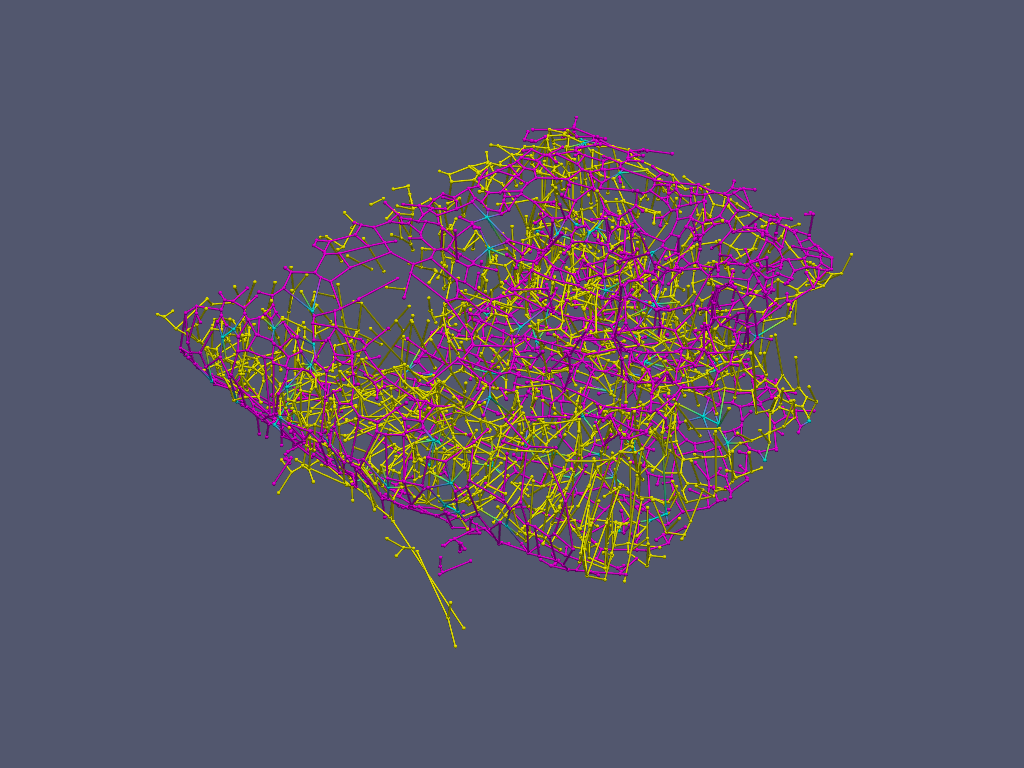

In [8]:
print("Graph from combined extraction with contraction.")
mesh_viewer.renderNXGraph(G_contract_einf, vtk = 0, backend = "static")

#### Link addition pipeline - alternatively to creating new contracted nodes (imo better), just link nodes that are very close. 

In [9]:
dist_mat_sparse = pp.network_sparse_distance_matrix(nodes_n, nodes_l, 0.05)
merged_edges_link = pd.concat([edges_l, edges_n], ignore_index = True)

new_links = pd.DataFrame(data = np.zeros((dist_mat_sparse.nnz, len(merged_edges_link.columns))), columns=merged_edges_link.columns)

average_edge = merged_edges_link.median()
ld_ratio = average_edge[0] / average_edge[1]

i = -1
for key, val in dist_mat_sparse.items():
    i = i+ 1
    new_links.loc[i][2:] = average_edge
    new_links.loc[i]["distance"] = float(val)
    new_links.loc[i]["length"] = float(val*ld_ratio)
    new_links.loc[i]["node1_degree"] = nodes_n.loc[str(key[0]) + "n"]["degree"] +1 
    new_links.loc[i]["node2_degree"] = nodes_l.loc[str(key[1]) + "l"]["degree"] +1
    new_links.loc[i]["node1id"] = str(key[0]) + "n"
    new_links.loc[i]["node2id"] = 1


new_links["node1id"] = [str(elem[0]) + "n" for elem in dist_mat_sparse.keys()]
new_links["node2id"] = [str(elem[1]) + "l" for elem in dist_mat_sparse.keys()]

merged_edges_link_f = pd.concat([merged_edges_link, new_links], ignore_index = True)
merged_nodes_link_f = pd.concat([nodes_l.loc[:,["pos_x", "pos_y", "pos_z"]], nodes_n.loc[:,["pos_x", "pos_y", "pos_z"]]])


# create a new graph based on the old information
G_link = pp.createGraph(merged_nodes_link_f, merged_edges_link_f)
G_link_einf = pp.convertToEinfach(G_link, self_loops = False, isolates = False)

print(G_link.order())
print(G_link.size())

4013
5653


Graph from combined extraction with additional links.


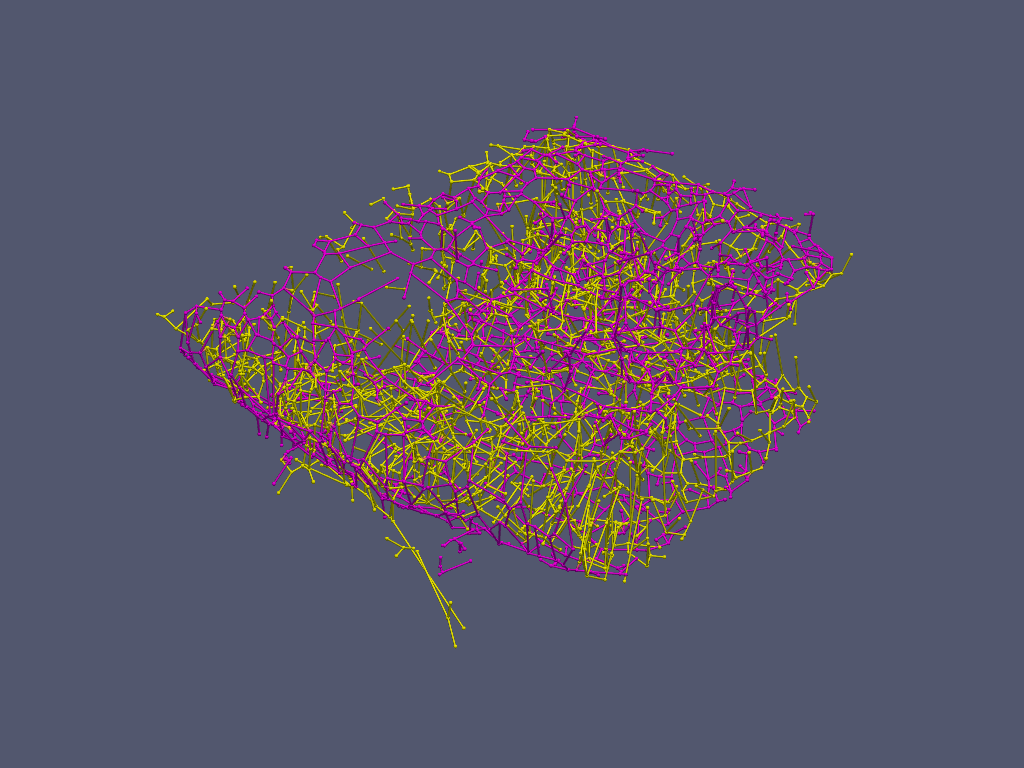

In [10]:
print("Graph from combined extraction with additional links.")
mesh_viewer.renderNXGraph(G_link_einf, vtk = 0, backend = "static")

#### Start the classification pipeline

In [11]:
# create the ground truth for the node class

# defines the graph to work with
all_nodes = list(G_contract_einf.nodes)



nerve_class = np.array([elem[-1] == "n" for elem in all_nodes])*0
lymph_class = np.array([elem[-1] == "l" for elem in all_nodes])*1
combined_class = np.array([elem[-1] == "c" for elem in all_nodes])*2
class_assign = nerve_class+lymph_class+combined_class


# create the training and testing masks
train_mask = np.random.choice(np.arange(0, len(class_assign)), size= int(len(class_assign)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(class_assign)), train_mask)

# convert to torch tensor objects
train_mask= torch.tensor(train_mask)
test_mask= torch.tensor(test_mask)

np.random.seed(1234567)
unique, counts = np.unique(class_assign[train_mask], return_counts=True)
print("Train-Mask Class Distribution: ")
print(unique)
print(counts)

print("Test-Mask Class Distribution: ")
unique, counts = np.unique(class_assign[test_mask], return_counts=True)
print(unique)
print(counts)


# convert the graph to a networkx graph

from torch_geometric.utils.convert import from_networkx
networkXG = from_networkx(G_contract_einf)
networkXG.y = torch.tensor(class_assign)


Train-Mask Class Distribution: 
[0 1 2]
[1402 1673   60]
Test-Mask Class Distribution: 
[0 1 2]
[374 398  12]


In [12]:
num_feat = networkXG.x.shape[1]
num_class = len(np.unique(networkXG.y))
netGCN = nodeClassifier.GCN_VS
netSAGE = nodeClassifier.SAGE_VS

modelGCN = nodeClassifier.nodeClassifier(netGCN, hidden_channels=32, features = np.arange(num_feat),classes = num_class, num_layers= 6, lr = 0.002)
modelSAGE = nodeClassifier.nodeClassifier(netSAGE, hidden_channels=32, features = np.arange(num_feat),classes = num_class, num_layers= 6, lr = 0.002)

models = [modelGCN, modelSAGE]
#models = [modelGCN]


epochs = 20
loss_l = np.zeros((epochs, len(models)))
acc_l = np.zeros((epochs, len(models)))
for epoch in range(1, epochs +1):
      for i, model in enumerate(models):
            loss = model.train(networkXG, train_mask)
            loss_l[epoch-1, i] = loss.detach().numpy().copy()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            test_acc = model.test(networkXG, test_mask)
            acc_l[epoch-1, i] = test_acc

for model in models:
      test_acc = model.test(networkXG, test_mask)
      print(f'Test Accuracy: {test_acc:.4f}')

#100 iter:
#13: 58.75%       trash
#12: 58.75%       trash
#11: 62.03%
#10: 69.11 %
#9:  58.75 %      trash
#8:  78.69 %
#7:  78.40 %
#6:  81.08 %
#5:  58.75 %      trash
#4:  68.69 %
#3:  79.97 %
#2:  58.75 %      trash
#1:  79.97 %
#0:  58.75 %      trash

#all:        82.56 %
#no trash:   81.11 %
# >75:       81.96 %
#[1,6,8,10]: 80.77 %

#500 iter:
#all:        82.56 %


Epoch: 001, Loss: 192.6339
Epoch: 001, Loss: 1.1294
Epoch: 002, Loss: 116.1133
Epoch: 002, Loss: 1.0977
Epoch: 003, Loss: 92.4317
Epoch: 003, Loss: 1.0681
Epoch: 004, Loss: 69.7232
Epoch: 004, Loss: 1.0356
Epoch: 005, Loss: 52.5005
Epoch: 005, Loss: 1.0060
Epoch: 006, Loss: 37.5913
Epoch: 006, Loss: 0.9790
Epoch: 007, Loss: 34.0781
Epoch: 007, Loss: 0.9493
Epoch: 008, Loss: 29.0551
Epoch: 008, Loss: 0.9160
Epoch: 009, Loss: 27.6393
Epoch: 009, Loss: 0.8889
Epoch: 010, Loss: 26.0629
Epoch: 010, Loss: 0.8633
Epoch: 011, Loss: 22.5347
Epoch: 011, Loss: 0.8495
Epoch: 012, Loss: 21.5678
Epoch: 012, Loss: 0.8371
Epoch: 013, Loss: 19.6274
Epoch: 013, Loss: 0.8347
Epoch: 014, Loss: 16.4066
Epoch: 014, Loss: 0.8418
Epoch: 015, Loss: 15.0662
Epoch: 015, Loss: 0.8408
Epoch: 016, Loss: 13.9022
Epoch: 016, Loss: 0.8423
Epoch: 017, Loss: 12.3485
Epoch: 017, Loss: 0.8300
Epoch: 018, Loss: 11.1765
Epoch: 018, Loss: 0.8201
Epoch: 019, Loss: 10.3180
Epoch: 019, Loss: 0.8134
Epoch: 020, Loss: 10.6033
Epo

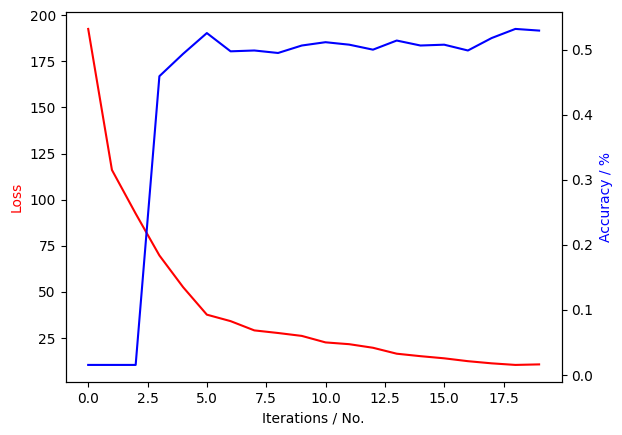

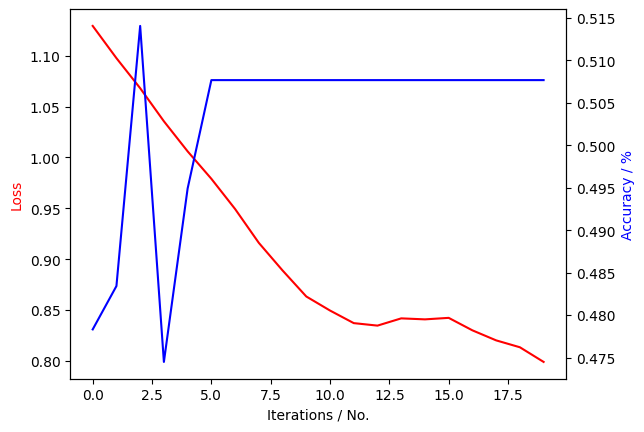

In [13]:
for i in range(len(models)):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loss_l[:,i], color = "red")
    ax2.plot(acc_l[:,i], color = "blue")

    ax1.set_xlabel('Iterations / No.')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Accuracy / %', color='b')



# Try node classification for the dual graph.

In [14]:
#graph to turn dual
L = pp.makeDual(G_link_einf)
class_label_list, node_lab, node_lab_explain =  pp.getLablesForDual(L)



networkDualXG = from_networkx(L)
networkDualXG.y = torch.tensor(class_label_list)



for key,val in node_lab.items():
    print("Class Label: " + str(node_lab[key]))
    print("Edge Type: " + str(node_lab_explain[val]))


node_lab_explain

Class Label: 0
Edge Type: ('l', 'l')
Class Label: 1
Edge Type: ('n', 'n')
Class Label: 2
Edge Type: ('l', 'n')


/home/laurin/.local/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  data[key] = torch.tensor(value)


{0: ('l', 'l'), 1: ('n', 'n'), 2: ('l', 'n')}

In [15]:
# create the training and testing masks
train_mask_dual = np.random.choice(np.arange(0, len(class_label_list)), size= int(len(class_label_list)*0.8), replace = False)
test_mask_dual = np.delete(np.arange(0, len(class_label_list)), train_mask_dual)

# convert to torch tensor objects
train_mask_dual= torch.tensor(train_mask_dual)
test_mask_dual= torch.tensor(test_mask_dual)


num_feat_dual = networkDualXG.x.shape[1]
num_class_dual = len(np.unique(networkDualXG.y))


In [16]:
optimizer = torch.optim.Adam
criterion = torch.nn.CrossEntropyLoss

modelGCN = nodeClassifier.nodeClassifier(netGCN, hidden_channels=32, features = np.arange(num_feat_dual),classes = num_class_dual, num_layers= 6)
modelSAGE = nodeClassifier.nodeClassifier(netSAGE, hidden_channels=32, features = np.arange(num_feat_dual),classes = num_class_dual, num_layers= 6)


models = [modelGCN, modelSAGE]


epochs = 20
loss_l = np.zeros((epochs, len(models)))
acc_l = np.zeros((epochs, len(models)))
for epoch in range(1, epochs +1):
      for i, model in enumerate(models):
            loss = model.train(networkDualXG, train_mask_dual)
            loss_l[epoch-1, i] = loss.detach().numpy().copy()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            test_acc = model.test(networkDualXG, test_mask_dual)
            acc_l[epoch-1, i] = test_acc

for model in models:
      test_acc = model.test(networkDualXG, test_mask_dual)
      print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 17773.4316
Epoch: 001, Loss: 1.1869
Epoch: 002, Loss: 7546.8413
Epoch: 002, Loss: 1.0761
Epoch: 003, Loss: 7291.0806
Epoch: 003, Loss: 1.0392
Epoch: 004, Loss: 7274.0806
Epoch: 004, Loss: 0.9882
Epoch: 005, Loss: 6151.3340
Epoch: 005, Loss: 0.9475
Epoch: 006, Loss: 3568.5557
Epoch: 006, Loss: 0.9492
Epoch: 007, Loss: 3401.9651
Epoch: 007, Loss: 0.9516
Epoch: 008, Loss: 3071.7964
Epoch: 008, Loss: 0.9616
Epoch: 009, Loss: 2402.3750
Epoch: 009, Loss: 0.9331
Epoch: 010, Loss: 1982.8306
Epoch: 010, Loss: 0.9298
Epoch: 011, Loss: 1681.8820
Epoch: 011, Loss: 0.9321
Epoch: 012, Loss: 1134.8687
Epoch: 012, Loss: 0.9338
Epoch: 013, Loss: 1276.3497
Epoch: 013, Loss: 0.9337
Epoch: 014, Loss: 777.3638
Epoch: 014, Loss: 0.9278
Epoch: 015, Loss: 743.2369
Epoch: 015, Loss: 0.9210
Epoch: 016, Loss: 583.4423
Epoch: 016, Loss: 0.9183
Epoch: 017, Loss: 493.6214
Epoch: 017, Loss: 0.9187
Epoch: 018, Loss: 442.3137
Epoch: 018, Loss: 0.9174
Epoch: 019, Loss: 322.3356
Epoch: 019, Loss: 0.913

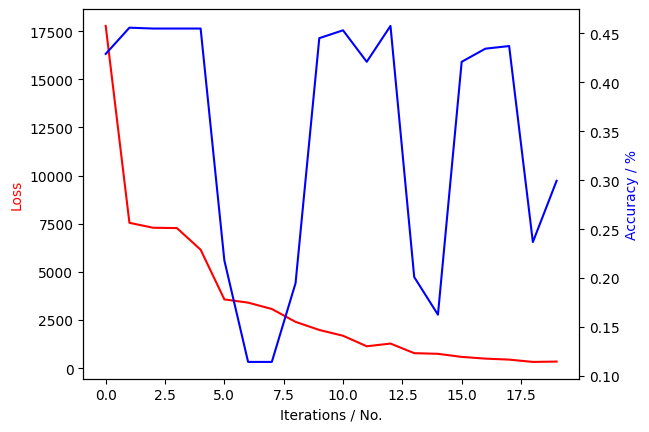

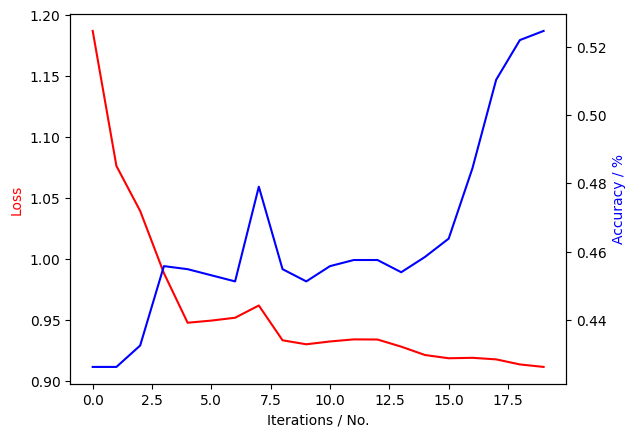

In [17]:
for i in range(len(models)):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loss_l[:,i], color = "red")
    ax2.plot(acc_l[:,i], color = "blue")

    ax1.set_xlabel('Iterations / No.')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Accuracy / %', color='b')

# Use wadb to perform parameter for hyperparameter search 

In [18]:
# give more room to the weight decay
sweep_variable_layyer_num = {
    "name": "gcn-sweep",
    "method": "bayes",
    "metric": {
        "name": "gcn/accuracy",
        "goal": "maximize",
    },
    "parameters": {
        
        "models": {
            "values": ["SAGE"]
        },
        "hidden_channels": {
            "values": [32, 64, 128]
        },

        "weight_decay": {
            "distribution": "normal",
            "mu": 1e-4,
            "sigma": 5e-5,
        },
        "lr": {
            "min": 1.5e-3,
            "max": 5e-2
        },
        "dropout": {
            "values": [0.5]
        },
        "num_layers": {
            "values": [8, 16]
        }
    }
}

# Register the Sweep with W&B
import wandb
#sweep_id = wandb.sweep(sweep_variable_layyer_num, project="node-classification_fh")

In [19]:
optimizerAdam = torch.optim.Adam
criterionCEL = torch.nn.CrossEntropyLoss

sweeper = nodeClassifier.nodeClassifierSweep(features = np.arange(num_feat_dual),classes = num_class_dual, optimizer = optimizerAdam, lossFunc = criterionCEL, graph = networkDualXG,  train_mask = train_mask, test_mask = test_mask, epochs = 200)

In [20]:
# Run the Sweeps agent
#wandb.agent(sweep_id, project="node-classification_fh", function=sweeper.agent_variable_size_model, count=20)

#sweeper.agent_variable_size_model()

In [21]:
bestMod = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_dual), classes = num_class_dual,num_layers= 6,  lr = 0.0001548, weight_decay= 0.000192)


epochs = 50
loss_l = np.zeros((epochs, 1))
acc_l = np.zeros((epochs, 1))
for epoch in range(1, epochs +1):
      loss = bestMod.train(networkDualXG, train_mask_dual)
      loss_l[epoch-1] = loss.detach().numpy().copy()
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
      test_acc = bestMod.test(networkDualXG, test_mask_dual)
      acc_l[epoch-1] = test_acc


test_acc = bestMod.test(networkDualXG, test_mask_dual)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.1656
Epoch: 002, Loss: 1.1335
Epoch: 003, Loss: 1.1115
Epoch: 004, Loss: 1.0845
Epoch: 005, Loss: 1.0662
Epoch: 006, Loss: 1.0594
Epoch: 007, Loss: 1.0442
Epoch: 008, Loss: 1.0302
Epoch: 009, Loss: 1.0179
Epoch: 010, Loss: 1.0203
Epoch: 011, Loss: 1.0071
Epoch: 012, Loss: 1.0027
Epoch: 013, Loss: 0.9969
Epoch: 014, Loss: 0.9962
Epoch: 015, Loss: 0.9866
Epoch: 016, Loss: 0.9770
Epoch: 017, Loss: 0.9770
Epoch: 018, Loss: 0.9795
Epoch: 019, Loss: 0.9758
Epoch: 020, Loss: 0.9768
Epoch: 021, Loss: 0.9634
Epoch: 022, Loss: 0.9599
Epoch: 023, Loss: 0.9661
Epoch: 024, Loss: 0.9630
Epoch: 025, Loss: 0.9579
Epoch: 026, Loss: 0.9564
Epoch: 027, Loss: 0.9536
Epoch: 028, Loss: 0.9579
Epoch: 029, Loss: 0.9458
Epoch: 030, Loss: 0.9532
Epoch: 031, Loss: 0.9513
Epoch: 032, Loss: 0.9466
Epoch: 033, Loss: 0.9481
Epoch: 034, Loss: 0.9462
Epoch: 035, Loss: 0.9501
Epoch: 036, Loss: 0.9397
Epoch: 037, Loss: 0.9349
Epoch: 038, Loss: 0.9431
Epoch: 039, Loss: 0.9428
Epoch: 040, Loss: 0.9361


Text(0, 0.5, 'Accuracy / %')

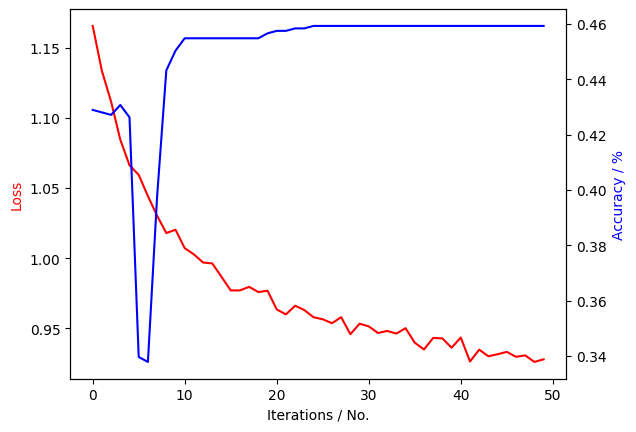

In [22]:

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_l, color = "red")
ax2.plot(acc_l, color = "blue")

ax1.set_xlabel('Iterations / No.')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy / %', color='b')

# Check the performance of the model on the graph created from the combined masks

In [23]:

# creating the graph
import graph_matching.graph_matching as gm

nodesFileComb =  "~/Documents/Intestine/combined-mask/nodes_bs2_fh.csv"
edgesFileComb = "~/Documents/Intestine/combined-mask/edges_bs2_fh.csv"

nodes_c = pd.read_csv(nodesFileComb, sep = ";", index_col= "id")
edges_c = pd.read_csv(edgesFileComb, sep = ";", index_col= "id")

print(nodes_c.shape[0])
print(edges_c.shape[0])

# scaling with the factors provided by luciano
nodes_c = pp.scalePosition(nodes_c, (1.65,1.65,6))

# creating the graph and labeling it 
G_contract_comb = pp.createGraph(nodes_c, edges_c)
G_contract_einf_comb = pp.convertToEinfach(G_contract_comb, self_loops = False, isolates = False)
G_contract_einf_comb_relab = gm.nearestNeighborLabeling(G_link_einf, G_contract_einf_comb)



3715
5135


Graph from combined extraction with additional links.


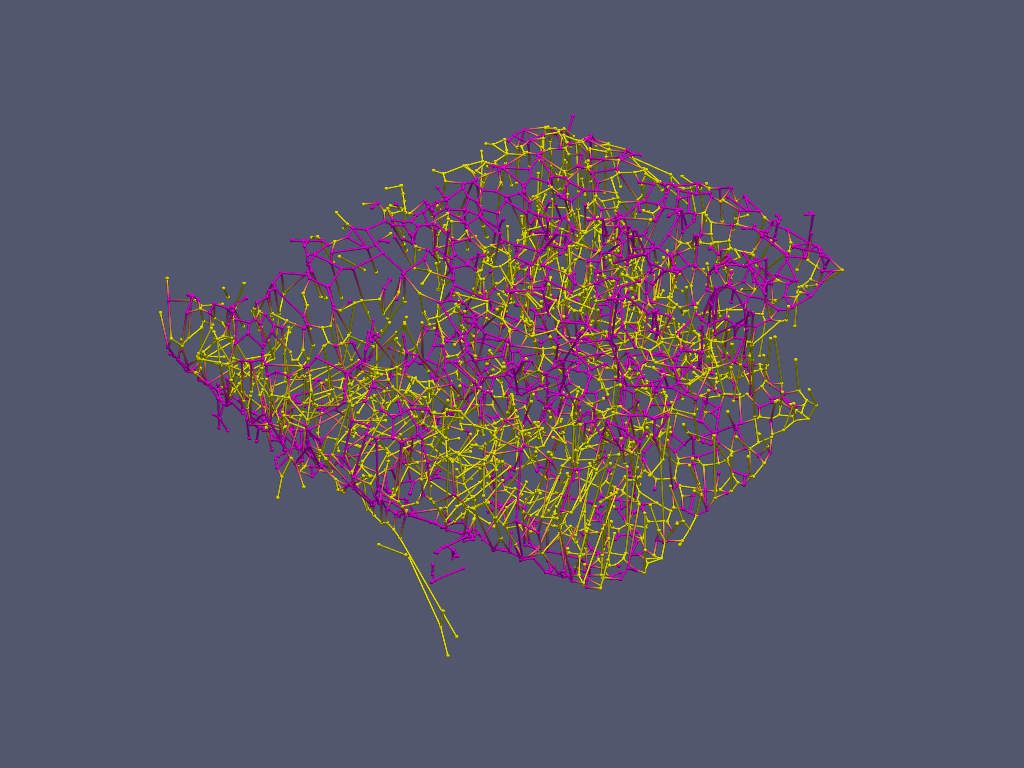

In [24]:
print("Graph from combined extraction with additional links.")
mesh_viewer.renderNXGraph(G_contract_einf_comb_relab, vtk = 0, backend = "static")

In [25]:
# creating the dual graph and converting to torch
L_comb = pp.makeDual(G_contract_einf_comb_relab)
networkDualXGComb = from_networkx(L_comb)


class_label_list_comb, node_lab, node_lab_explain_add =  pp.getLablesForDual(L_comb, node_lab)
networkDualXGComb.y = torch.tensor(class_label_list_comb)

0.48024316109422494


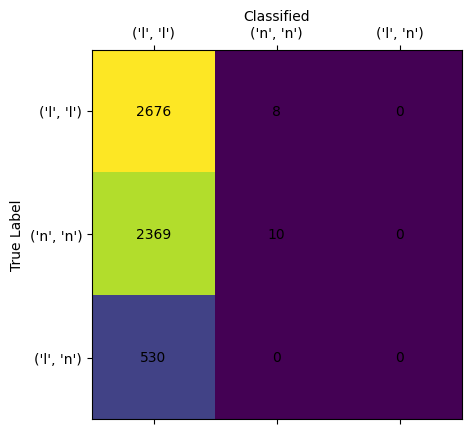

In [26]:
full_mask_dual = torch.tensor(np.arange(0, networkDualXG.y.shape[0]))
pred_whole = bestMod.predictions(networkDualXG, full_mask_dual)
pred_whole_acc = bestMod.test(networkDualXG, full_mask_dual)

lab_list = []
for k,v in node_lab_explain.items():
    lab_list.append(v)

print(pred_whole_acc)


ev.plot_confusion_matrix(np.array(networkDualXG.y), pred_whole, lab_list)

0.41


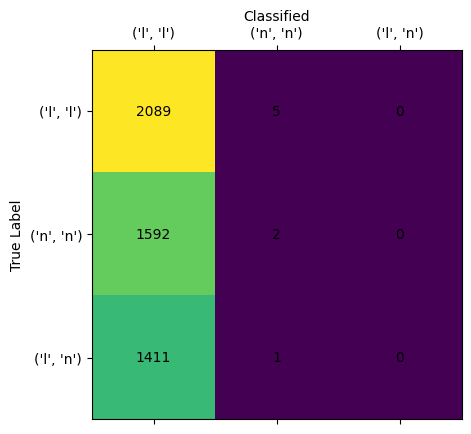

In [27]:
full_mask_dual_comb = torch.tensor(np.arange(0, networkDualXGComb.y.shape[0]))
pred_whole_comb = bestMod.predictions(networkDualXGComb, full_mask_dual_comb)
pred_whole_comb_acc = bestMod.test(networkDualXGComb, full_mask_dual_comb)

print(pred_whole_comb_acc)
ev.plot_confusion_matrix(np.array(networkDualXGComb.y), pred_whole_comb, lab_list)

Graph from combined extraction with additional links.


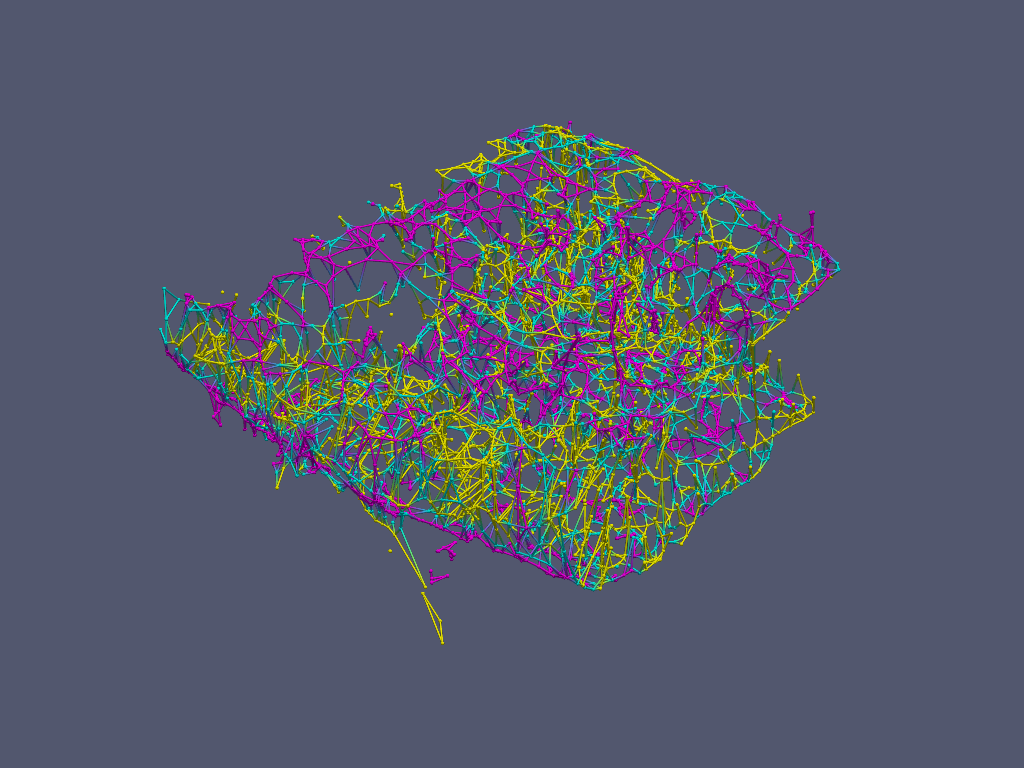

In [28]:
print("Graph from combined extraction with additional links.")
mesh_viewer.renderNXGraph(L_comb, dual = True, vtk = 0, backend = "static")

Graph from combined extraction with additional links.


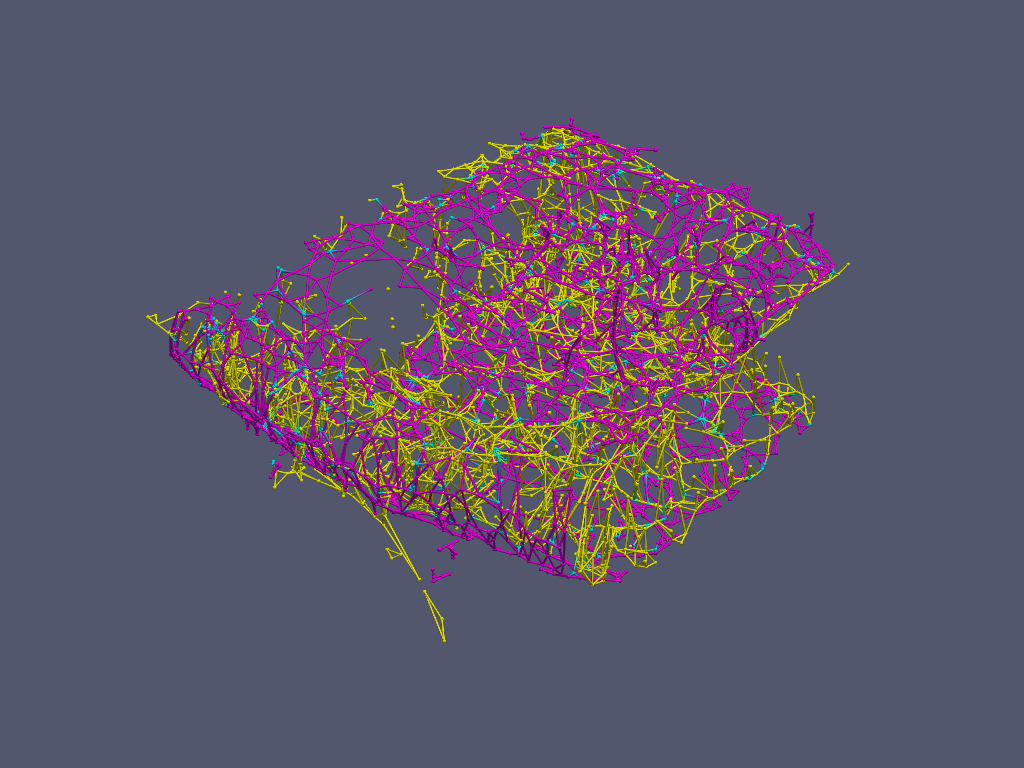

In [29]:
print("Graph from combined extraction with additional links.")
mesh_viewer.renderNXGraph(L, dual = True, vtk = 0, backend = "static")